In [1]:
import torch
import torch.nn as nn
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.datasets import VOCDetection
from torchvision.transforms import *
from torch.utils.data import DataLoader
from torchvision.utils import draw_bounding_boxes
import matplotlib.pyplot as plt
import sys
import os
sys.path.append("..")
from detection.faster_rcnn import RCNN

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    print("CUDA unavailable; switching to CPU")
    device = torch.device("cpu")

In [3]:
base_model = fasterrcnn_resnet50_fpn(weights = "DEFAULT", box_nms_thresh = 0.2)
model = RCNN(num_classes = 20, base_model = base_model).to(device)

In [4]:
transform = Compose([ToTensor()])
dataset = VOCDetection("~/datasets/VOCDetection", transform = transform)

In [5]:
name_to_label = {'pottedplant': 1, 'person': 2, 'motorbike': 3, 'train': 4,
               'dog': 5, 'diningtable': 6, 'horse': 7, 'bus': 8,
               'aeroplane': 9, 'sofa': 10, 'sheep': 11, 'tvmonitor': 12,
               'bird': 13, 'bottle': 14, 'chair': 15, 'cat': 16,
               'bicycle': 17, 'cow': 18, 'boat': 19, 'car': 20, 'bg': 0}
label_to_name = {value:key for key, value in name_to_label.items()}

In [6]:
def is_box_valid(box):
    if (box[0] < box[2]) and (box[1] < box[3]):
        return True
    else:
        return False
    
def process_voc(dataset):
    images, targets = [], []
    for sample in dataset:
        # get the bounding boxes
        sample_boxes = []
        sample_labels = []
        for obj in sample[1]["annotation"]["object"]:
            # get the bounding boxes
            box = obj["bndbox"]
            coords = torch.tensor([int(coord) for coord in box.values()])
            if not is_box_valid(coords):
                continue
            sample_boxes.append(coords)
            
            # get the corresponding labels
            name = obj["name"]
            label = name_to_label[name]
            sample_labels.append(label)

        if sample_boxes == []:
            continue
        sample_dict = {"boxes": torch.vstack(sample_boxes), 
                       "labels": torch.tensor(sample_labels)}

        # save the image
        image = sample[0]
        images.append(image)
        # save the targets
        targets.append(sample_dict)
    return images, targets

In [7]:
images, targets = process_voc(dataset)
def collate_fn(batch):
    return tuple(zip(*batch))
loader = DataLoader(list(zip(images, targets)),
                     batch_size = 8, 
                     collate_fn = collate_fn)

In [8]:
batch = next(iter(loader))
imgs, lbls = batch
images = tuple(img.to(device) for img in imgs)
labels = tuple({k:v.to(device) for k, v in d.items()} for d in lbls)

In [9]:
# for param in model.parameters():
#     param.requires_grad = False
# for param in model.box_predictor.parameters():
#     param.requires_grad = True

In [10]:
train = False
if train:
    epochs = 15
    opt = torch.optim.Adam(model.box_predictor.parameters(), lr = 1e-4)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor = 0.9, patience = 5)
    model.train().to(device)
    for epoch in range(epochs):
        print(f"Epoch: {epoch}")
        running_loss = 0.
        batches = 0
        for batch in loader:
            imgs, lbls = batch
            images = tuple(img.to(device) for img in imgs)
            labels = tuple({k:v.to(device) for k, v in d.items()} for d in lbls)

            opt.zero_grad()
            loss_vals = model(images, labels)
            loss = sum(loss_val for loss_val in loss_vals)
            loss.backward()
            opt.step()

            running_loss += loss
            batches += 1
        
        average_loss = running_loss/batches
        lr_scheduler.step(average_loss)
        print(f"Average Loss per Batch: {average_loss}")
    torch.save(model, "../model_weights/custom_object_detector.pt")
else:
    model = torch.load("../model_weights/custom_object_detector.pt", weights_only = False)

In [11]:
model.train()
with torch.no_grad():
    if model.training:
        class_loss, reg_loss, object_loss, rpn_loss = model(images, labels)
        print(f"Class Loss: {class_loss.item()} | Regression Loss: {reg_loss.item()}")
        print(f"Object Loss: {object_loss.item()} | RPN Loss: {rpn_loss.item()}")
    else:
        preds = model(images, labels)
        print(preds)

Class Loss: 0.21070845425128937 | Regression Loss: 0.12035562098026276
Object Loss: 0.008409151807427406 | RPN Loss: 0.010088302195072174


In [12]:
latents = model(images, labels, mode = "partial")
print(latents.shape)

torch.Size([4096, 1024])


In [87]:
sample = list(loader)[torch.randint(1, len(list(loader)), (1,))]
image = sample[0][0].unsqueeze(dim = 0).to(device)
target = sample[1][0]
model.eval().to(device)
out = model(image)[0]
boxes = out["boxes"]
labels = [int(label.cpu()) for label in out["labels"]]
labels = [label_to_name[label] for label in labels]
print(boxes)
print(labels)

tensor([[6.6774e+01, 1.9265e+01, 4.4860e+02, 3.6085e+02],
        [4.7065e-01, 1.9511e+02, 1.5348e+02, 3.6498e+02],
        [3.6988e+02, 2.8987e+00, 5.0000e+02, 3.3849e+02],
        [3.1711e+02, 2.1742e+02, 4.1973e+02, 3.0626e+02]], device='cuda:0',
       grad_fn=<StackBackward0>)
['person', 'person', 'person', 'chair']


In [88]:
image.shape

torch.Size([1, 3, 375, 500])

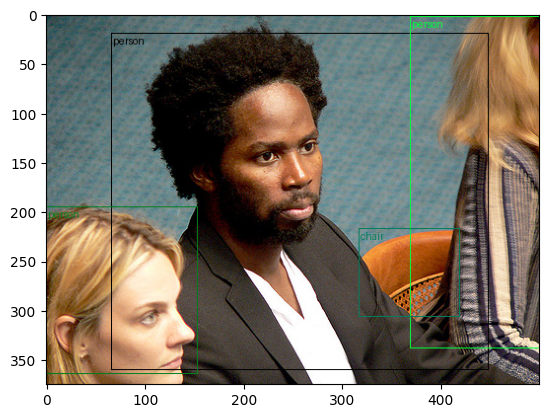

In [89]:
boxed = draw_bounding_boxes(image[0].cpu(), boxes, labels)
plt.imshow(boxed.permute(1, 2, 0))